# Dropout and Weight Regularization

## Douglas Rice

*This tutorial was originally created by Burt Monroe for his prior work with the Essex Summer School. I've updated and modified it.*

In this notebook, we'll show how to impose some forms of regularization (beyond early stopping) on your network through dropout and regularization penalties on weights. After completing this notebook, you should be familar with:


1. Dropout layers and practice
2. L1 Regularization
3. L2 Regularization




## Tensorflow

We'll be using Tensorflow [here](https://www.tensorflow.org/) and Keras [here](https://keras.io/) for building neural network models. Tensorflow is free and open-source (obviously) now, but it was initially developed internally by the folks at Google for their own neural network / AI development tasks. It was released publicly in 2015. Keras is the API built on top of TensorFlow; the idea is to make it "simpler" to build, evaluate, and compare complex neural networks. 

In [ ]:
!pip install tensorflow==2.5.0
!pip install -U tensorflow-text==2.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 454.3 MB 17 kB/s 
     |████████████████████████████████| 462 kB 62.5 MB/s 
     |████████████████████████████████| 1.2 MB 55.9 MB/s 
     |████████████████████████████████| 4.0 MB 50.5 MB/s 
     |████████████████████████████████| 14.8 MB 57.6 MB/s 
     |████████████████████████████████| 132 kB 69.8 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68713 sha256=f11c17aeff85c22f089eb90d2eb73e2ad080dc4f19d2eee5d74c842fa99d9651
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: n

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 31.3 MB/s 


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12521120983330866306
 xla_global_id: -1]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 200

## Get the Data

We'll use the feedforward neural network we just built in Tutorial Four as a stepping stone for learning dropout and regularization. The first step then is to do the same processing to get the data set up in the correct format for our analysis.


In [3]:
# Retrieve the training sequences.
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=5000)
# Retrieve the word index file mapping words to indices
word_index = keras.datasets.imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words
inverted_word_index = dict((i, word) for (word, i) in word_index.items())
# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in train_data[0])

In [ ]:
def vectorize_sequences(sequences, dimension = 5000):
    results = np.zeros((len(sequences), dimension))     # Creates an all-zero matrix of shape (len(sequences), dimension)
    for i, sequences in enumerate(sequences):
        results[i, sequences] = 1.                      # Sets specific indices of results[i] to 1s
    return results

# Vectorize test and training data
x_train = vectorize_sequences(train_data)               
x_test = vectorize_sequences(test_data)                 


In [ ]:
# Vectorize text and training labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')


In [ ]:
# Generate a validation set
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## Dropout

### Update the model architecture with Dropout layers.

Let's start with dropout. Dropout is a form of ensembling, or model averaging. Ensembling of different learners generally improves performance; the more well-estimated models we have, the better we can predict outcomes. 

Burt writes:

>Dropout essentially averages over different *subnetworks* -- that is, the original architecture with connections cut at random. This is an effective and inexpensive way to gain robustness, since the averaging is built into training of a single model. With something like *bagging* -- which estimates models based on *k* bootstrapped samples of the data -- there have to be *k* models trained. In any case, the idea is that this will help the model avoid relying too much on any given pattern and it will then be more general and robust.

>Typical advice is to apply Dropout at a rate of up to 50% on the outputs of hidden layers, and up to 20%, if at all, on the inputs. The intuition on input Dropout is that it adds robustness when there is redundancy among the features. Old school social science translation -- when there's multicollinearity. For, say, image data, there is tremendous redundancy; knocking out random pixels doesn't make it much harder for humans to understand the image. For our problem, this amounts to the question of whether sentiment of a text should still be discernible with 10 or 20% of the words missing at random.

>In general, Dropout is most important in highly parameterized / complicated / expressive models, so we shouldn't expect this to have too much impact on final performance for this simple network. This is just to demonstrate how it works.

In our simple feedforward network, we can add dropout by adding a `Dropout` "layer" between any two node layers. The main parameter is `rate` which defines the probability, in any training timestep, that an input will be set to zero. All remaining weights are scaled up for that time step. 

Let's add three dropout layers. The first is on the input layer; note that we keep the rate to 10% for that layer. After the second and third layers, we add equivalent dropout layers at a rate of 30%. You'll notice below that the addition of dropout layers doesn't influence the number of parameters. 



In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [ ]:
# Determine model architecture
model = models.Sequential()
model.add(layers.Dropout(.1, input_shape=(5000,)))
model.add(layers.Dense(16, activation = 'relu', input_shape=(5000,)))
model.add(layers.Dropout(.3))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(.3))
model.add(layers.Dense(1, activation= 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                80016     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 80,305
Trainable params: 80,305
Non-trainable params: 0
____________________________________________________

## Compile and Evaluate

With the model architecture specified, we turn to compiling it. Recall that we need to specify our optimization function, our loss function, and metrics for evaluation. We'll stick with what we did before.

In [ ]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=50,
                   batch_size=512,
                   validation_data=(x_val,y_val))

Epoch 1/50
30/30 [==============================] - 3s 23ms/step - loss: 0.6310 - accuracy: 0.6438 - val_loss: 0.5046 - val_accuracy: 0.8214
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.4759 - accuracy: 0.7921 - val_loss: 0.3761 - val_accuracy: 0.8625
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.3814 - accuracy: 0.8514 - val_loss: 0.3181 - val_accuracy: 0.8780
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.3152 - accuracy: 0.8816 - val_loss: 0.2925 - val_accuracy: 0.8834
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.2789 - accuracy: 0.8973 - val_loss: 0.2840 - val_accuracy: 0.8830
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.2463 - accuracy: 0.9115 - val_loss: 0.2801 - val_accuracy: 0.8848
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.2293 - accuracy: 0.9182 - val_loss: 0.2801 - val_accuracy: 0.8862
Epoch 8/50
30

In [ ]:
# .fit() returns a history object which is a dictionary containing data about everything that happened during training

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the loss and accuracy metrics from training for both the training and validation sets. 

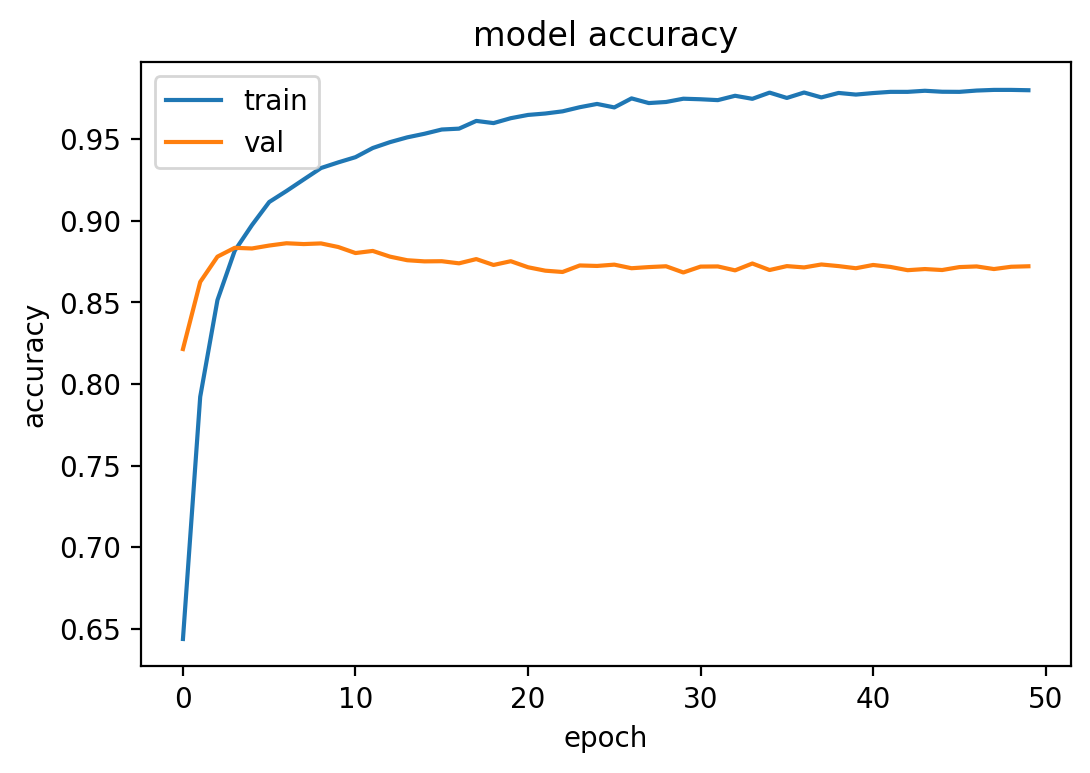

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

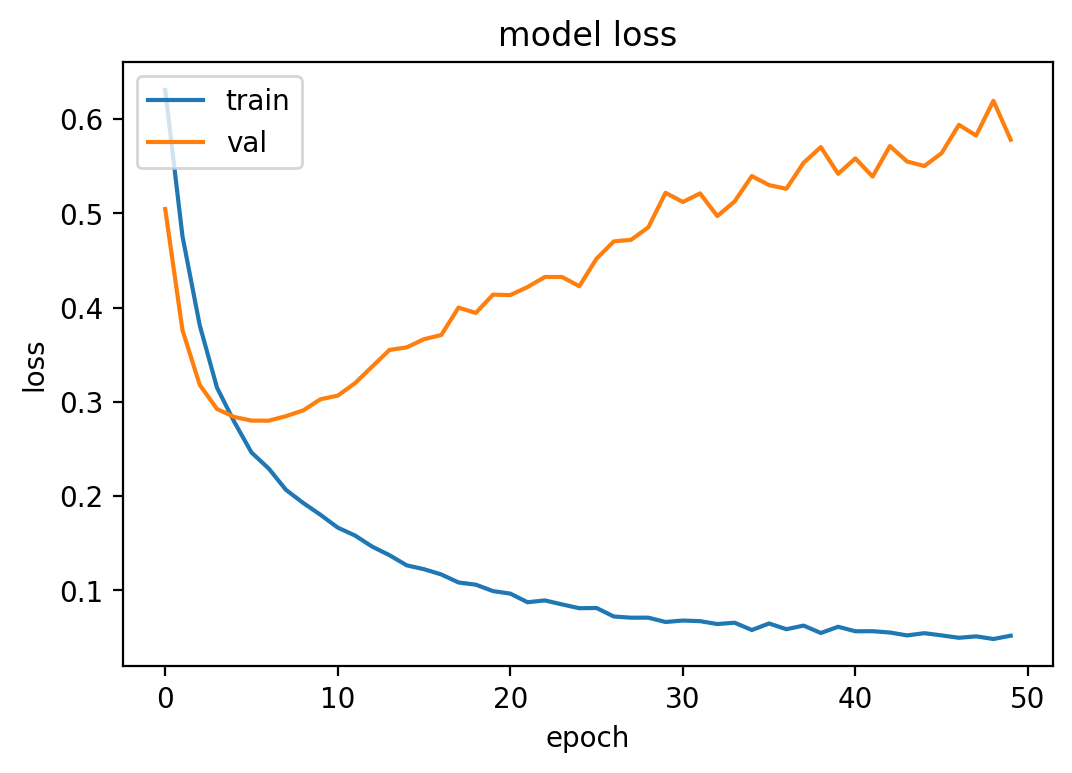

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Recall that in our earlier model, it looked like we should stop around 4 or 5 epochs to avoid overfitting. In the model with dropout, it looks liked we should stop around 5 or 6 epochs, so not a big difference. Let's do it again but stop early.

In [ ]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=5,
                   batch_size=512,
                   validation_data=(x_val,y_val))

Epoch 1/5
30/30 [==============================] - 2s 36ms/step - loss: 0.0498 - accuracy: 0.9803 - val_loss: 0.5789 - val_accuracy: 0.8717
Epoch 2/5
30/30 [==============================] - 1s 20ms/step - loss: 0.0552 - accuracy: 0.9783 - val_loss: 0.6489 - val_accuracy: 0.8709
Epoch 3/5
30/30 [==============================] - 1s 23ms/step - loss: 0.0524 - accuracy: 0.9802 - val_loss: 0.6216 - val_accuracy: 0.8736
Epoch 4/5
30/30 [==============================] - 1s 21ms/step - loss: 0.0527 - accuracy: 0.9807 - val_loss: 0.6303 - val_accuracy: 0.8724
Epoch 5/5
30/30 [==============================] - 1s 17ms/step - loss: 0.0482 - accuracy: 0.9815 - val_loss: 0.6565 - val_accuracy: 0.8734


In [ ]:
# .fit() returns a history object which is a dictionary containing data about everything that happened during training

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the loss and accuracy metrics from training for both the training and validation sets. 

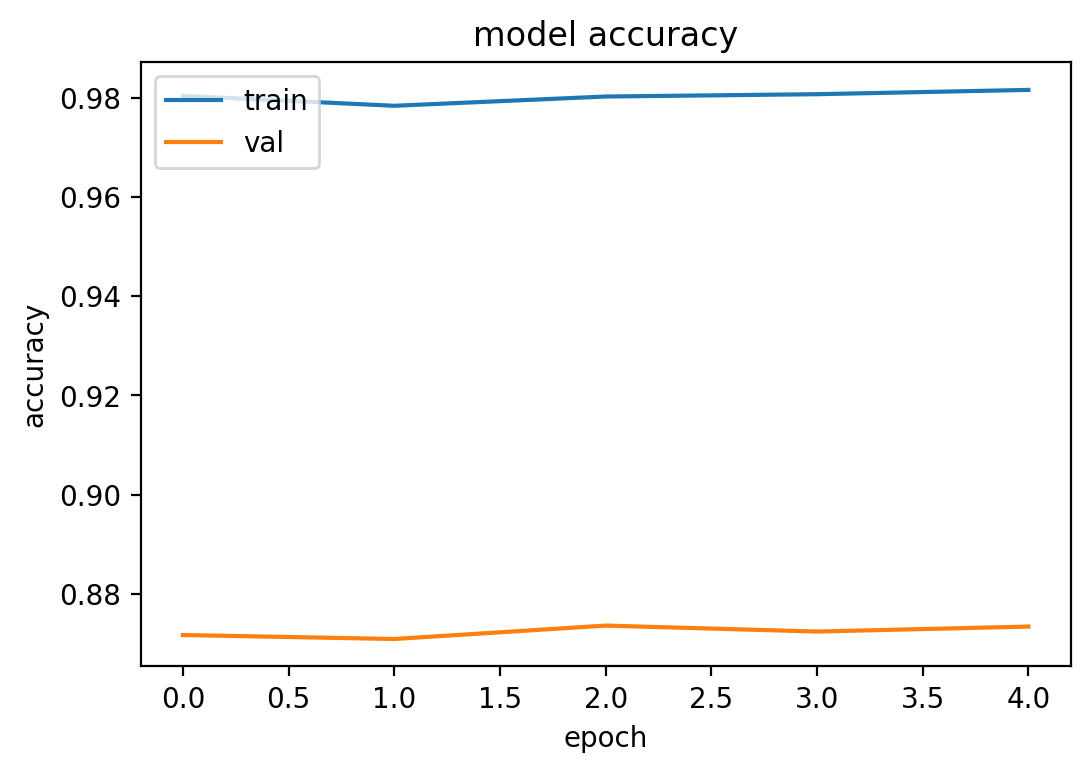

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

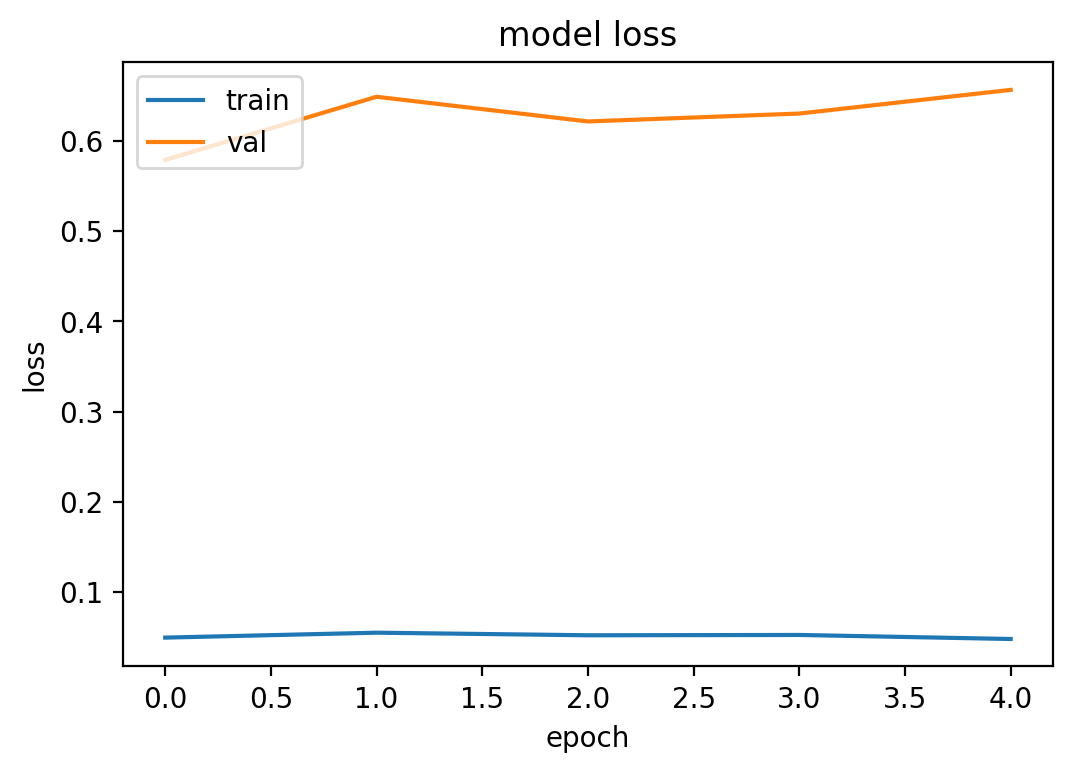

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.6945 - accuracy: 0.8609


[0.6944986581802368, 0.8608800172805786]

86% accuracy (again, give or take with a stochastic element here). In general, it looks like the model with dropout is doing a tiny bit better than the baseline.

### Add a LOT of dropout

For illustration purposes (only), let's way overdo it. We'll have a dropout rate of 50% for the input layer, then a dropout rate of 80% for the following two layers. With all that dropout, we'll pump the epochs back up.

In [ ]:
# Determine model architecture
model = models.Sequential()
model.add(layers.Dropout(.5, input_shape=(5000,)))
model.add(layers.Dense(16, activation = 'relu', input_shape=(5000,)))
model.add(layers.Dropout(.8))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(.8))
model.add(layers.Dense(1, activation= 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                80016     
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 80,305
Trainable params: 80,305
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=50,
                   batch_size=512,
                   validation_data=(x_val,y_val))

Epoch 1/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6701 - accuracy: 0.5579 - val_loss: 0.6353 - val_accuracy: 0.8273
Epoch 2/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6631 - accuracy: 0.5602 - val_loss: 0.6240 - val_accuracy: 0.8233
Epoch 3/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6613 - accuracy: 0.5619 - val_loss: 0.6182 - val_accuracy: 0.8286
Epoch 4/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6500 - accuracy: 0.5669 - val_loss: 0.5957 - val_accuracy: 0.8443
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6409 - accuracy: 0.5779 - val_loss: 0.5774 - val_accuracy: 0.8590
Epoch 6/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6353 - accuracy: 0.5872 - val_loss: 0.5695 - val_accuracy: 0.8619
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6284 - accuracy: 0.5876 - val_loss: 0.5510 - val_accuracy: 0.8571
Epoch 8/50
30

In [ ]:
# .fit() returns a history object which is a dictionary containing data about everything that happened during training

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

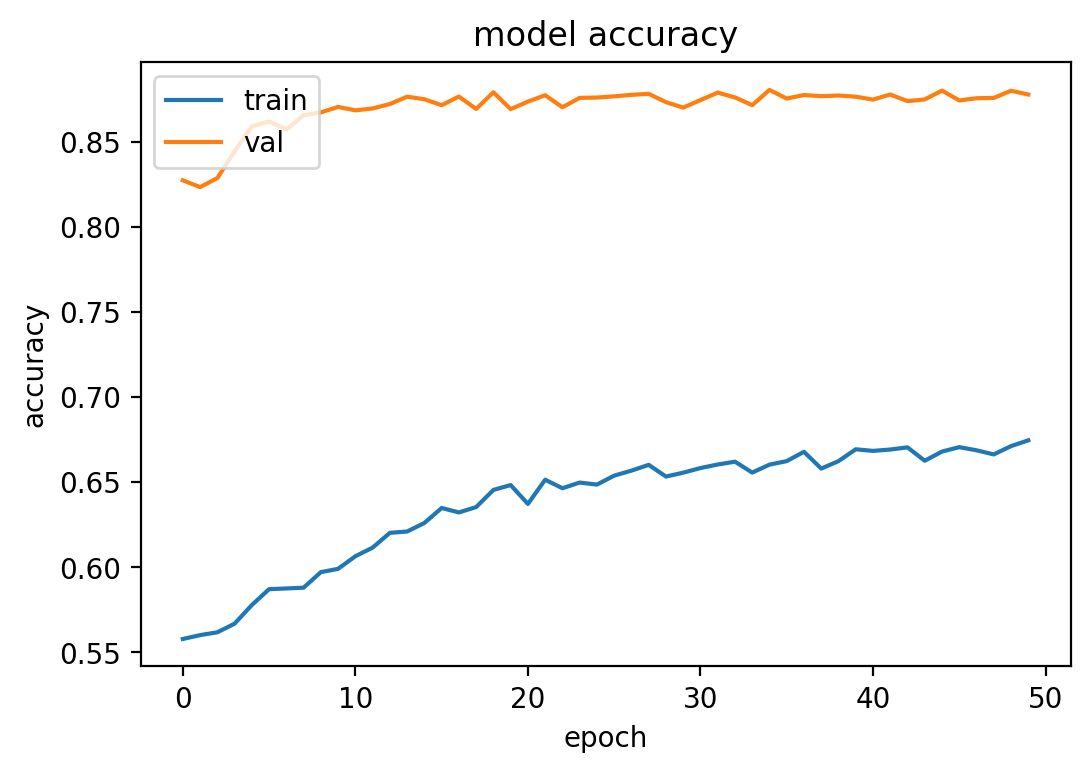

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

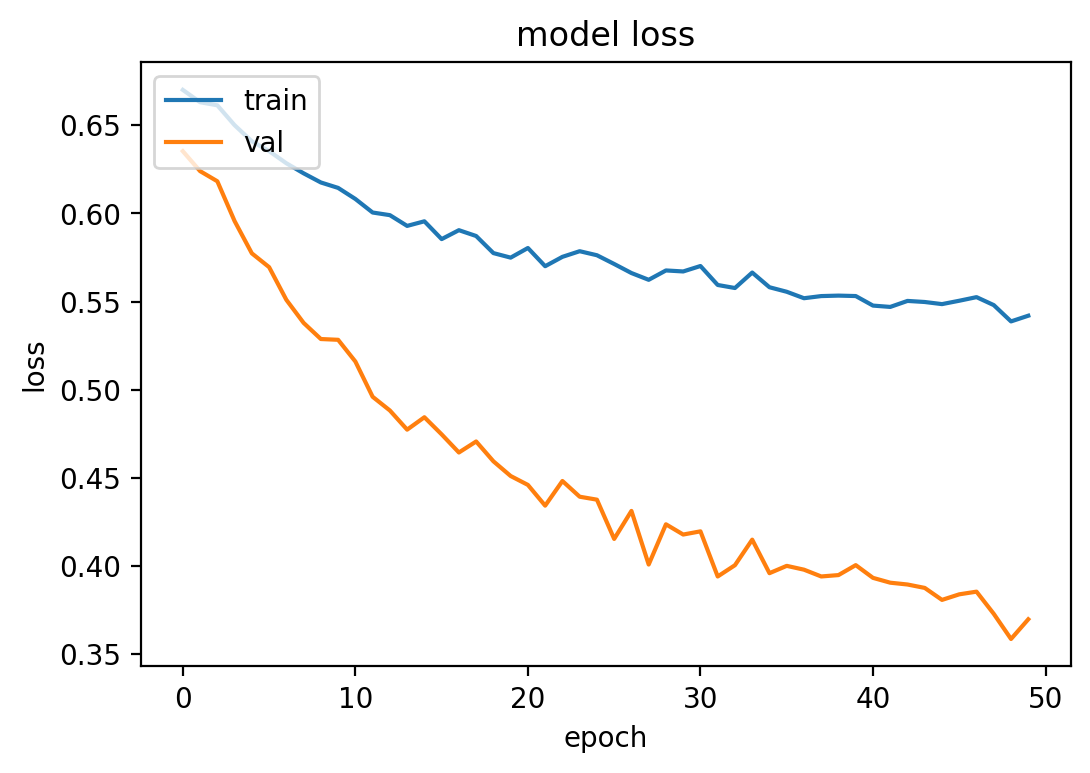

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

That's the first time we've seen that. The training accuracy never catches up to the validation accuracy (and likewise for loss). In fact, the training accuracy never gets above about 80% because it's missing most of its connections on each run. 

## Regularization

We can also update the model by imposing *regularization*, or imposing a penalty on large weights (in other contexts, you can think about this as imposing a penalty on really large coefficients). The value of imposing that regularization is to avoid overfitting; we'll limit the influence of particular weights. 

There are two forms of regularization to consider: L1 and L2. The L1 regularization imposes a penalty based on the absolute value of the weight, and in doing so shrinks the weights of less important features towards zero. In doing so, it acts as a *feature selection* tool. The L2 regularization  imposes a penalty based on the squared value of the weight. In doing so, it has a "shrinkage" effect, making weights/coefficients smaller. 

## Adding a Regularization Layer

The process within Keras for adding layers is straightforward. We simply add `kernel_regularizer` to a layer. In doing so, we apply that regularizer to the **incoming** weights. You can apply an L1 penalty, an L2 penalty, or both.

### L1-penalty on upper layers

Let's start by applying an L1-penalty on the upper (i.e., final) layers of the network. All of the specifications will follow the model that we've been developing to this point, but with the regularization now added on these incoming weights at the upper layers of our network. The only thing we need to specify beyond our prior steps is the L1 regularization factor; the basic thing to know is that as you increase this factor, the greater the penalty. The default value is 0.01. 

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
# Determine model architecture
model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape=(5000,)))
model.add(layers.Dense(16, activation = 'relu', kernel_regularizer = regularizers.L1(0.01)))
model.add(layers.Dense(1, activation= 'sigmoid', kernel_regularizer = regularizers.L1(0.01)))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                80016     
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 80,305
Trainable params: 80,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=15,
                   batch_size=512,
                   validation_data=(x_val,y_val))

Epoch 1/15
30/30 [==============================] - 1s 18ms/step - loss: 1.1546 - accuracy: 0.7427 - val_loss: 0.9932 - val_accuracy: 0.8441
Epoch 2/15
30/30 [==============================] - 0s 12ms/step - loss: 0.8827 - accuracy: 0.8793 - val_loss: 0.8279 - val_accuracy: 0.8747
Epoch 3/15
30/30 [==============================] - 0s 12ms/step - loss: 0.7450 - accuracy: 0.9069 - val_loss: 0.7470 - val_accuracy: 0.8834
Epoch 4/15
30/30 [==============================] - 0s 12ms/step - loss: 0.6584 - accuracy: 0.9189 - val_loss: 0.6918 - val_accuracy: 0.8854
Epoch 5/15
30/30 [==============================] - 0s 12ms/step - loss: 0.5899 - accuracy: 0.9322 - val_loss: 0.6499 - val_accuracy: 0.8830
Epoch 6/15
30/30 [==============================] - 0s 12ms/step - loss: 0.5339 - accuracy: 0.9379 - val_loss: 0.6123 - val_accuracy: 0.8815
Epoch 7/15
30/30 [==============================] - 0s 12ms/step - loss: 0.4843 - accuracy: 0.9435 - val_loss: 0.5832 - val_accuracy: 0.8809
Epoch 8/15
30

In [ ]:
# .fit() returns a history object which is a dictionary containing data about everything that happened during training

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

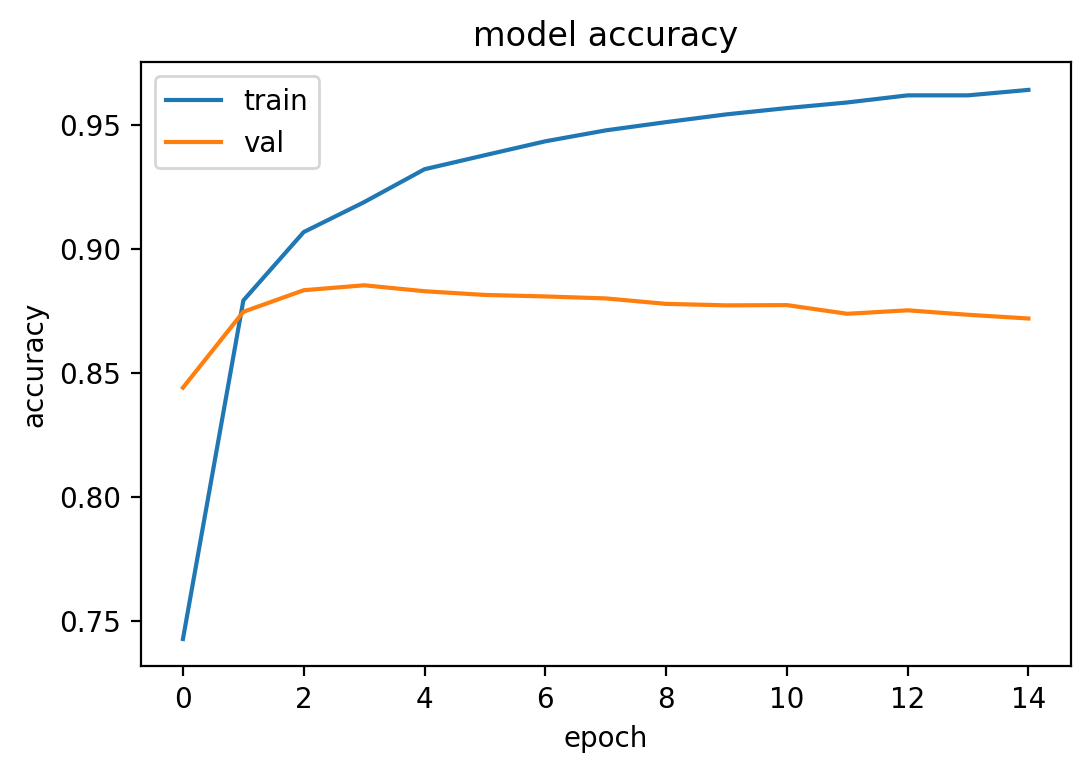

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

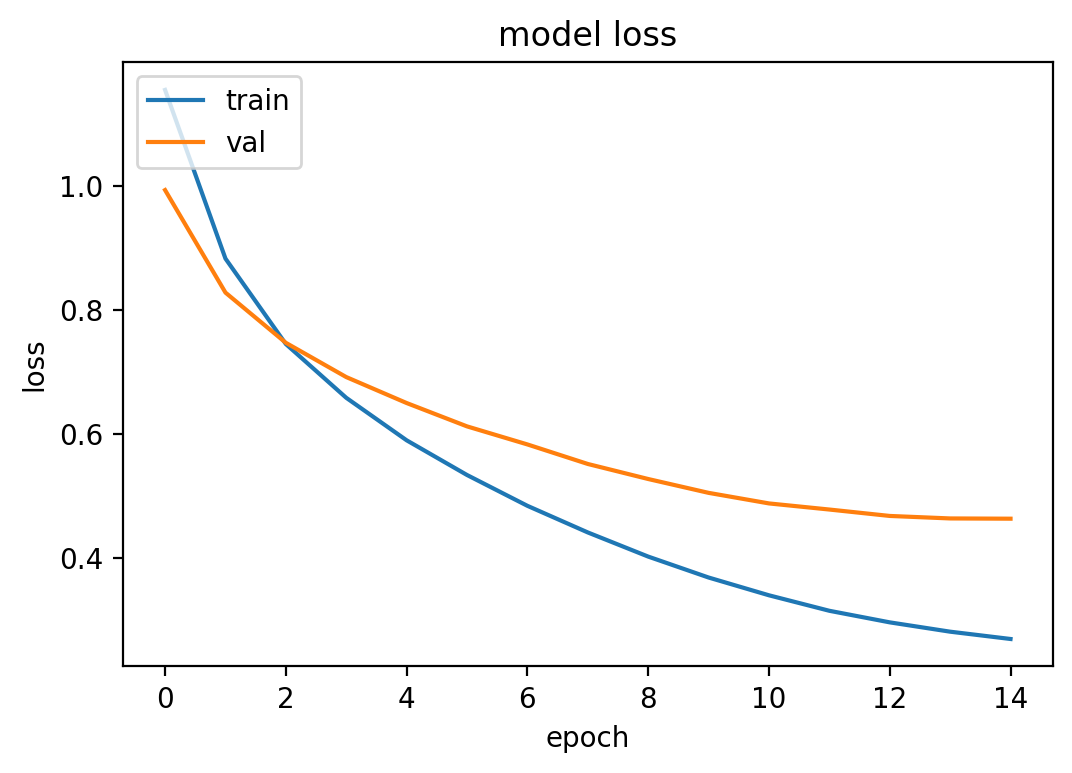

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

These are interesting. Note that, within the *validation* set, we are actually moving in the *wrong* direction after the 13th (loss) or 4th (accuracy) epoch. That divergence between metrics is something that we haven't really encountered before. If we wanted to avoid overfitting, which should we rely on? Generally speaking, we should rely on loss when the two diverge. As intuition, the loss function has more granularity (i.e., it tells us how close we are in making our cutpoints) whereas accuracy is just concerned about right/wrong. 



In [ ]:
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.4812 - accuracy: 0.8663


[0.4811874330043793, 0.8662800192832947]

And again about 87% accuracy (although it looks like we could have gotten higher with the earlier stopping).

### Something more like the LASSO -- L1-penalty on the first layer.

We can also apply L1 regularization on the inputs to the first hidden layer. For folks that are familiar, this is closer to the logic of LASSO regressions, where we are pushing closer to a feature selection model. The model is pushing the weights at the first stage (i.e., word to hidden node) to be zero, meaning that word would not influence the output. 

In [ ]:
# Determine model architecture
model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape=(5000,), kernel_regularizer = regularizers.L1(0.01)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation= 'sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16)                80016     
_________________________________________________________________
dense_15 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total params: 80,305
Trainable params: 80,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=30,
                   batch_size=512,
                   validation_data=(x_val,y_val))

Epoch 1/30
30/30 [==============================] - 1s 28ms/step - loss: 6.6830 - accuracy: 0.5217 - val_loss: 1.6835 - val_accuracy: 0.6120
Epoch 2/30
30/30 [==============================] - 0s 17ms/step - loss: 1.2232 - accuracy: 0.7181 - val_loss: 0.8872 - val_accuracy: 0.7237
Epoch 3/30
30/30 [==============================] - 1s 17ms/step - loss: 0.8212 - accuracy: 0.7299 - val_loss: 0.7862 - val_accuracy: 0.7404
Epoch 4/30
30/30 [==============================] - 1s 18ms/step - loss: 0.7721 - accuracy: 0.7397 - val_loss: 0.7560 - val_accuracy: 0.7583
Epoch 5/30
30/30 [==============================] - 0s 17ms/step - loss: 0.7399 - accuracy: 0.7573 - val_loss: 0.7307 - val_accuracy: 0.7580
Epoch 6/30
30/30 [==============================] - 0s 17ms/step - loss: 0.7128 - accuracy: 0.7730 - val_loss: 0.6969 - val_accuracy: 0.7913
Epoch 7/30
30/30 [==============================] - 1s 17ms/step - loss: 0.6918 - accuracy: 0.7911 - val_loss: 0.6818 - val_accuracy: 0.7988
Epoch 8/30
30

In [ ]:
# .fit() returns a history object which is a dictionary containing data about everything that happened during training

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

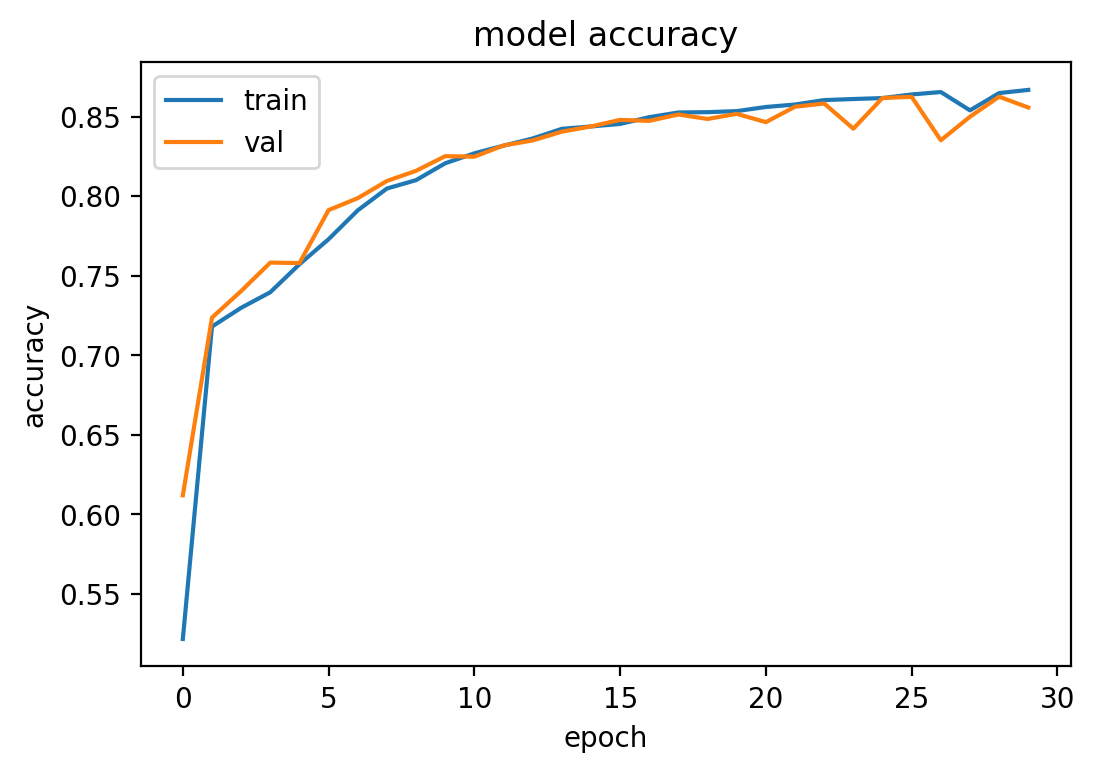

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

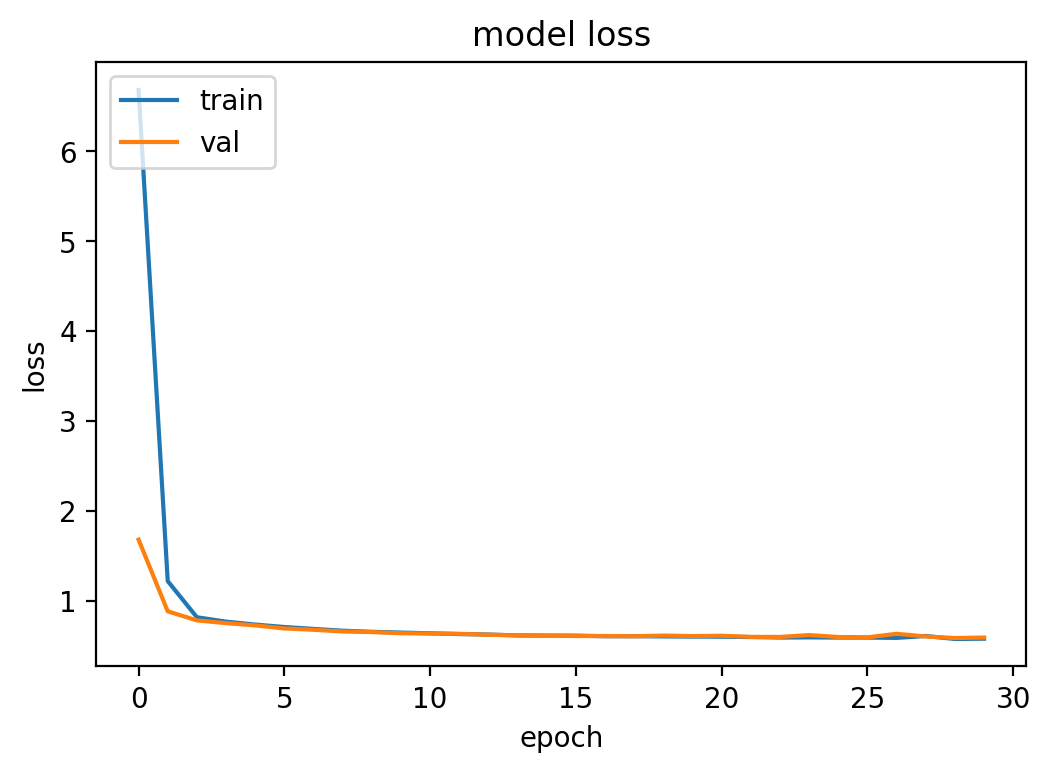

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Look at that! It definitely dampens the overfitting. The match of the training/validation sets in terms of accuracy seems promising. Let's evaluate with our held-out set.

In [ ]:
model.evaluate(x_test, y_test)

782/782 [==============================] - 3s 3ms/step - loss: 0.5996 - accuracy: 0.8545


[0.5995948314666748, 0.8545200228691101]

Ah, 86%. We've definitely limited our overfitting, but we're also not doing quite as well. Some more fine-tuning (and maybe some longer training sessions) is probably in order.

## Inside the Weights

We've been estimating these models and looking at the outcomes, but it's worthwhile to return to what the models are doing now relative to the baseline: adjusting the weights. Let's take a look at the weights.

In [ ]:
netweights = np.matmul(np.matmul(model.get_weights()[0],model.get_weights()[2]),model.get_weights()[4])
netweights.shape

(5000, 1)

In [ ]:
#featurelist = sorted(inverted_word_index.items(), key=lambda x: x[1], reverse=True)
featuretuplelist = sorted(inverted_word_index.items())
featurelist=[featuretuplelist[i][1] for i in range(len(featuretuplelist))]

In [ ]:
coef_df=pd.DataFrame(netweights[1:3000,0],['UNK','UNK','UNK']+featurelist[0:2996],columns=["coef"])
coef_df['freq']=x_train.sum(axis=0)[1:3000].tolist()
coef_df.sort_values(by='coef', ascending=False)

,coef,freq
7,1.024466,832.0
excellent,0.980041,1777.0
perfect,0.819722,1355.0
8,0.810503,810.0
great,0.743594,6305.0
...,...,...
poorly,-0.877632,629.0
boring,-0.955051,1506.0
awful,-1.247968,1442.0
waste,-1.335877,1303.0


In [ ]:
coef_df.sort_values(by='coef',ascending=False).head(25)

,coef,freq
7,1.024466,832.0
excellent,0.980041,1777.0
perfect,0.819722,1355.0
8,0.810503,810.0
great,0.743594,6305.0
amazing,0.686202,1108.0
wonderful,0.630151,1439.0
best,0.581967,4894.0
incredible,0.575983,496.0
today,0.566896,846.0


In [ ]:
coef_df.sort_values(by='coef',ascending=True).head(25)

,coef,freq
worst,-1.410274,2265.0
waste,-1.335877,1303.0
awful,-1.247968,1442.0
boring,-0.955051,1506.0
poorly,-0.877632,629.0
fails,-0.864460,562.0
mess,-0.860454,590.0
poor,-0.836514,1599.0
dull,-0.757642,706.0
disappointing,-0.724783,394.0


Well, the numbers are different, but the words are basically the same as we saw in the past. We're finding the same important features in this set as we did in the models without regularization. As was mentioned earlier, it's possible that regularization just isn't that useful with a relatively uncomplicated model (as here). 

That said, one way you *can* see the influence of regularization is by thinking about what those changes in the magnitude of the weights represent. Not only are these weights greater, regularization also means lots of weights have been pushed towards zero. Let's look at the distribution of the terms according to their weights (first plot) and the overall distribution of weights (second plot) to see exactly what I mean.

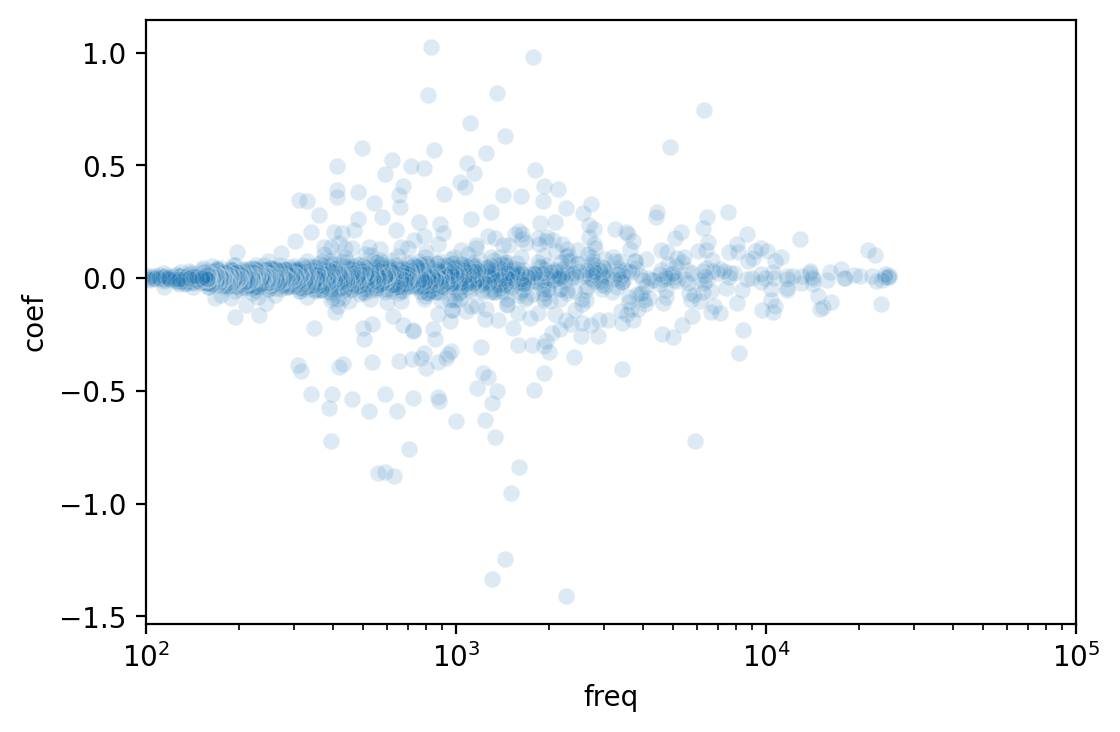

In [ ]:
import seaborn as sns
coefplot = sns.scatterplot(data = coef_df, x = "freq", y = "coef", alpha = .15)
coefplot.set(xscale="log")
coefplot.set(xlim=[100,100000])
plt.show(coefplot)